In [1]:
import torch
import torch.nn as nn

#(輸入通道數, 輸出通道數, 卷積核大小)
conv = nn.Conv2d(3, 16, kernel_size=3) #建構一個卷積層
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [2]:
conv.weight.shape, conv.bias.shape
#weight shape: out_ch x in_ch x kernel_size x kernel_size
#bias shape: out_ch 

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [3]:
from torchvision import datasets, transforms

data_path = '../data/p1ch7'  #檔案路徑
transformed_cifar10 = datasets.CIFAR10( #對訓練資料集進行正規化
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), #各通道的平均值，計算方法參閱 LearningFromImageExample
                             (0.2470, 0.2435, 0.2616)) #各通道的標準差，計算方法參閱 LearningFromImageExample
    ])
)

cifar10_val = datasets.CIFAR10( #對驗證資料集進行正規化
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), #驗證集必須使用和訓練集相同的平均值及標準差來正規化
                             (0.2470, 0.2435, 0.2616))
    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#7.2 區分鳥和飛機
label_map = {0: 0, 2: 1} #將飛機的類別標籤對應到 0 (原本為 0)；將小鳥的標籤對應到 1 (原本為 2)
class_name = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) #取出原有訓練資料集中，飛機及小鳥的圖片
          for img, label in transformed_cifar10
          if label in [0,2]]
cifar2_val = [(img, label_map[label]) #取出原有驗證資料集中，飛機及小鳥的圖片
              for img, label in cifar10_val
              if label in [0, 2]]

In [5]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) #先在 img 的第 0 軸加入批次軸，再傳進 conv 模組
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

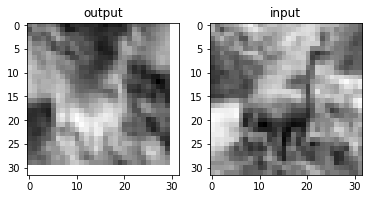

In [6]:
from matplotlib import pyplot as plt

ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [8]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) #這裡設定了填補
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape #輸出圖片大小與原始圖片大小一致

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [9]:
with torch.no_grad():
    conv.bias.zero_() #將卷積層的 bias 設為 0

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0) #將卷積層的 weights 設為 1/9 (這樣就能讓每個輸出值等於所有像素值的平均值)

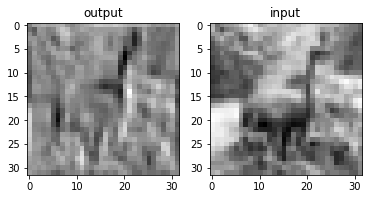

In [11]:
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()
#output 變成原始圖片的平滑化版本
#由於輸出圖片中每個像素的值都是其區域像素的平均，因此輸出像素間的相關性很高，值的變化也更加平滑

In [18]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0], #手動設定核權重矩陣中的值
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

In [19]:
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape #輸出圖片大小與原始圖片大小一致

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

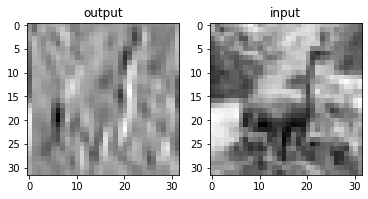

In [20]:
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()
#此卷積核的功能為 將 右邊的像素值 減去 左邊的像素值
#此為一個邊緣偵測(edge-detection)核

In [24]:
pool = nn.MaxPool2d(2) #將池化區域設成 2
output = pool(img.unsqueeze(0)) #此處一樣要先在第 0 軸添加一個批次軸
img.unsqueeze(0).shape, output.shape #圖片大小已縮小成一半

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [32]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), #第一層卷積層
    nn.Tanh(),
    nn.MaxPool2d(2), #第一層最大池化層
    nn.Conv2d(16, 8, kernel_size=3, padding=1), #第二層卷積層
    nn.Tanh(),
    nn.MaxPool2d(2), #第二層最大池化層
    nn.Flatten(), #Flatten在書裡先被省略，這裡是自己補上的，這裡省略了很重要的東西
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [27]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [31]:
model(img.unsqueeze(0))

tensor([[-0.1884, -0.0594]], grad_fn=<AddmmBackward>)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #定義需要用到的模組物件
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) #之前省略的部分(扁平化卷積模組輸出)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [34]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [65]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #僅定義卷積模組與線性模組
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) #將最大化池和激活函數替換成函數式API
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        #out = out.view(-1, 8 * 8 * 8) #之前省略的部分(扁平化卷積模組輸出) 書裡使用 view 自己壓平
        out = self.flatten(out) #可用 flatten 讓 PyTorch 幫忙壓平
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [62]:
model = Net() #建立一個 Net()物件
model(img.unsqueeze(0)) #嘗試運行模型

tensor([ 0.1150, -0.0944], grad_fn=<AddBackward0>)

In [79]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.") #可以根據輸出結果知道是否有可用的 GPU

Training on device cuda.


In [85]:
import datetime #使用 Python 內建的 datetime 模組

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1): #控制訓練週期的迴圈，注意範圍是從 1 開始到 n_epochs，而非從 0 開始
        loss_train = 0.0
        for imgs, labels in train_loader: #走訪 train_loader，每次會取出一批次的訓練資料及標籤
            imgs = imgs.to(device = device) #將 imgs 和 labels 轉移到指定的硬體(由 device 變數決定)
            labels = labels.to(device = device) 
            
            outputs = model(imgs) #將一批次資料餵入模型中
            loss = loss_fn(outputs, labels) #計算損失(最小化的目標)
            
            optimizer.zero_grad() #將上一輪的梯度清除
            loss.backward() #反向運算一次，以便取得損失對所有可訓練參數的梯度
            optimizer.step() #更新模型參數
            
            loss_train += loss.item() #將此次訓練週期中的所有損失加總起來；必須使用 item() 將損失轉換為 Python 數字
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))
            #將損失總和除以批次量(即 train_loader 的長度)，已取得每批次的平均損失(相較於總和，以平均值來測量損失更加值觀)

In [86]:
#先將 cifar 資料集隨機洗牌，然後我們每次讀取時會由其中抽取一批次( 64筆)的資料
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device) #建立模型
#將模型所有參數移到 GPU 上。所有的模型參數及輸入資料都要移到 GPU 上，否則會有錯誤訊息提醒你:
#張量不在同一個硬體上(PyTorch 的算符不知原混用 GPU 和 CPU 上的資烙

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) #隨機梯度下降優化器
loss_fn = nn.CrossEntropyLoss() #交叉熵損失函數

#呼叫稍早之前定義的訓練迴圈
training_loop(n_epochs = 100, 
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader,
             )

2021-08-22 16:46:14.366183 Epoch 1, Training loss 0.5893626040334154
2021-08-22 16:46:17.246123 Epoch 10, Training loss 0.3295111513821183
2021-08-22 16:46:20.479506 Epoch 20, Training loss 0.2878500471828849
2021-08-22 16:46:23.693540 Epoch 30, Training loss 0.26162087214980156
2021-08-22 16:46:26.911584 Epoch 40, Training loss 0.24312472723092243
2021-08-22 16:46:30.142778 Epoch 50, Training loss 0.22602944831796892
2021-08-22 16:46:33.361936 Epoch 60, Training loss 0.2110026646761378
2021-08-22 16:46:36.581419 Epoch 70, Training loss 0.19781206348899064
2021-08-22 16:46:39.799103 Epoch 80, Training loss 0.18491125026136446
2021-08-22 16:46:43.000716 Epoch 90, Training loss 0.16998820066167292
2021-08-22 16:46:46.205959 Epoch 100, Training loss 0.1592594383723417


In [88]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False) #取得訓練資料集(推論階段，不用洗牌)

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False) #取得驗證資料集(推論階段，不用洗牌)

def validate(model, train_loader, val_loader): #定義用來計算模型準確度(在訓練資料及驗證資料上)的函式
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad(): #由於不需要做參數更新，因此不須計算梯度
            for imgs, labels in loader:
                imgs = imgs.to(device = device) #將 imgs 和 labels 轉移到指定的硬體(由 device 變數決定)
                labels = labels.to(device = device) 
                
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) #取得最大值所在的索引，並存進 predicted 陣列
                total += labels.shape[0] #計算一共有多少樣本
                #比較預測陣列跟標籤陣列，進而得到一個布林陣列。接著算出該批次中有多少預測是正確的
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct/total))#印出準確率
        
validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.88


In [89]:
torch.save(model.state_dict(), data_path + '/pretrained/birds_vs_airplane.pt') #包含 model 的所有參數，但不包含模型架構

In [92]:
loaded_model = Net().to(device=device) #必須確保在儲存參數之後，Net類別的定義未被更改
#載入剛剛儲存的模型參數，並透過 map_location 直接指示 PyTorch 要載入到哪一個裝置
loaded_model.load_state_dict(torch.load(data_path + '/pretrained/birds_vs_airplane.pt', map_location=device))

<All keys matched successfully>

In [93]:
class NetWidth(nn.Module): #創建一個名為 NetWidth 的子類別
    def __init__(self):
        super().__init__()
        #僅定義卷積模組與線性模組
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) #將最大化池和激活函數替換成函數式API
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        #out = out.view(-1, 8 * 8 * 8) #之前省略的部分(扁平化卷積模組輸出) 書裡使用 view 自己壓平
        out = self.flatten(out) #可用 flatten 讓 PyTorch 幫忙壓平
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out
    
class NetWidth(nn.Module): #創建一個名為 NetWidth 的子類別
    def __init__(self, n_channel): #也可將寬度參數化
        super().__init__()
        #僅定義卷積模組與線性模組
        self.n_channel = n_channel
        self.conv1 = nn.Conv2d(3, n_channel, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channel, n_channel // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((n_channel // 2) * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) #將最大化池和激活函數替換成函數式API
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        #out = out.view(-1, 8 * 8 * 8) #之前省略的部分(扁平化卷積模組輸出) 書裡使用 view 自己壓平
        out = self.flatten(out) #可用 flatten 讓 PyTorch 幫忙壓平
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [96]:
model = NetWidth(32).to(device = device)
sum(p.numel() for p in model.parameters())

38386

In [97]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader: 
            imgs = imgs.to(device = device)
            labels = labels.to(device = device) 
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            #這裡是手動 weight decay，也可在 optimizer 裡就給參數 weight_decay
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) #若要改用 L1常規化，只需將 pow() 改為 abs()即可
            loss = loss + l2_lambda * l2_norm #把 L2懲罰項加入損失值
            
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
            
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [102]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1 =32): 
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        #個別神經元被丟棄的機率為 0.4，換言之，經過 dropout 處理後，只會留下大約 60% 的神經元，且每一次留下的神經元基本是不相同
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear((n_chans1 // 2) * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        #out = out.view(-1, 8 * 8 * 8) #之前省略的部分(扁平化卷積模組輸出) 書裡使用 view 自己壓平
        out = self.flatten(out) #可用 flatten 讓 PyTorch 幫忙壓平
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [99]:
#用來控制 dropout 是否啟動
model.eval()
model.train()

NetWidth(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [101]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1 =32): 
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.con1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.con2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2)
        self.fc1 = nn.Linear((n_chans1 // 2) * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        out = self.conv1.batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2.batchnorm(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        #out = out.view(-1, 8 * 8 * 8) #之前省略的部分(扁平化卷積模組輸出) 書裡使用 view 自己壓平
        out = self.flatten(out) #可用 flatten 讓 PyTorch 幫忙壓平
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [103]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1 =32): 
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((n_chans1 // 2) * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2) #此處多加了一層卷積模組，變成總共有 3 層卷積層
        #out = out.view(-1, 8 * 8 * 8) #之前省略的部分(扁平化卷積模組輸出) 書裡使用 view 自己壓平
        out = self.flatten(out) #可用 flatten 讓 PyTorch 幫忙壓平
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [ ]:
class NetRes(nn.Module):
    def __init__(self, n_chans1 =32): 
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((n_chans1 // 2) * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) #殘差處理
        
        #out = out.view(-1, 8 * 8 * 8) #之前省略的部分(扁平化卷積模組輸出) 書裡使用 view 自己壓平
        out = self.flatten(out) #可用 flatten 讓 PyTorch 幫忙壓平
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [108]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super().__init__()
        #由於 BatchNorm 層會抵消偏值的作用，因此這裡將偏值設為 False
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        
        #這裡使用了客製的初始化方法 .kaiming_normal_，其利用與原始 ResNet 論文相同的標準差產生正規化的隨機元素。
        #在初始階段，batch_norm 的輸出分佈平均值為 0、標準差為 0.5
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [110]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=1):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)])) #將 n_blocks 個殘差塊組合在一起
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = self.flatten(out)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [119]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = NetResDeep(32, 3).to(device=device) 

optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.9, weight_decay=1e-3) #隨機梯度下降優化器
loss_fn = nn.CrossEntropyLoss() #交叉熵損失函數

model.train()
#呼叫稍早之前定義的訓練迴圈
training_loop(n_epochs = 200, 
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader,
             )

2021-08-22 19:58:48.463146 Epoch 1, Training loss 0.41343583897420555
2021-08-22 19:58:52.920702 Epoch 10, Training loss 0.17855342553489528
2021-08-22 19:58:57.884057 Epoch 20, Training loss 0.07576872475421542
2021-08-22 19:59:02.842903 Epoch 30, Training loss 0.015435591232547667
2021-08-22 19:59:07.783312 Epoch 40, Training loss 0.0032385249846840314
2021-08-22 19:59:12.756212 Epoch 50, Training loss 0.001958803034974796
2021-08-22 19:59:17.749145 Epoch 60, Training loss 0.001706862446420476
2021-08-22 19:59:22.737815 Epoch 70, Training loss 0.001496302496414234
2021-08-22 19:59:27.758555 Epoch 80, Training loss 0.05298970217051305
2021-08-22 19:59:32.804266 Epoch 90, Training loss 0.0018397006167285737
2021-08-22 19:59:37.816476 Epoch 100, Training loss 0.0013244326349131311
2021-08-22 19:59:42.800519 Epoch 110, Training loss 0.0012356443769983639
2021-08-22 19:59:47.773212 Epoch 120, Training loss 0.001210782686574681
2021-08-22 19:59:52.749085 Epoch 130, Training loss 0.00128248

In [121]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False) #取得訓練資料集(推論階段，不用洗牌)

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False) #取得驗證資料集(推論階段，不用洗牌)
        
model.eval()
validate(model, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.90


In [122]:
torch.save(model.state_dict(), data_path + '/pretrained/birds_vs_airplane_resnet.pt')

In [124]:
loaded_model = NetResDeep(32, 3).to(device=device) 
loaded_model.load_state_dict(torch.load(data_path + '/pretrained/birds_vs_airplane_resnet.pt', map_location=device))

<All keys matched successfully>